# 16. 프로젝트 : SRGAN 활용하기
## 프로젝트 1 : 직접 고른 이미지로 SRGAN 실험하기

앞서 사용했던 DIV2K 데이터셋은 bicubic interpolation을 이용해 가로 및 세로 픽셀 수를 1/4로 줄인 저해상도 이미지와 원래 고해상도 이미지 사이에서 학습되었습니다. 이 데이터셋으로 학습된 SRGAN를 이용해 좋은 결과를 얻기 위해서는 위와 같은 과정이 동일하게 진행되는 것이 좋습니다.

아래와 같이 두 가지 다른 단계를 거쳐서 직접 고른 이미지에 대해 SRGAN을 적용해 봅시다. (모델 학습을 진행하는 건 아닙니다❗) 테스트할 이미지를 고를 때, DIV2K 의 학습 데이터셋과 비슷한 종류의 이미지가 좋습니다. 일반적으로 자연, 동물, 건물 등의 이미지가 학습에 사용되었으며, 이와 달리 애니메이션 등의 이미지는 고해상도로 잘 변환되지 않을 수 있습니다.

특정 데이터셋에서만 학습되었기 때문에, 일반적으로 좋지 않은 결과가 나올 가능성이 높습니다. 결과와 상관없이 아래 과정만 잘 수행해봅시다.
  

## 모델 생성    
### 1) 데이터 준비하기

In [1]:
from skimage import data

import tensorflow as tf
import cv2
from skimage.metrics import peak_signal_noise_ratio, structural_similarity

import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds

In [2]:
tfds.load("div2k/bicubic_x4")

{'train': <PrefetchDataset shapes: {hr: (None, None, 3), lr: (None, None, 3)}, types: {hr: tf.uint8, lr: tf.uint8}>,
 'validation': <PrefetchDataset shapes: {hr: (None, None, 3), lr: (None, None, 3)}, types: {hr: tf.uint8, lr: tf.uint8}>}

In [3]:
train, valid = tfds.load(
    "div2k/bicubic_x4", 
    split=["train","validation"],
    as_supervised=True
)
def preprocessing(lr, hr):
    hr = tf.cast(hr, tf.float32) /255.
        
    # 이미지의 크기가 크므로 (96,96,3) 크기로 임의 영역을 잘라내어 사용합니다.
    hr_patch = tf.image.random_crop(hr, size=[96,96,3])
        
    # 잘라낸 고해상도 이미지의 가로, 세로 픽셀 수를 1/4배로 줄입니다
    # 이렇게 만든 저해상도 이미지를 SRGAN의 입력으로 사용합니다.
    lr_patch = tf.image.resize(hr_patch, [96//4, 96//4], "bicubic")
    return lr_patch, hr_patch

train = train.map(preprocessing).shuffle(buffer_size=10).repeat().batch(8)
valid = valid.map(preprocessing).repeat().batch(8)

## SRGAN 구현하기

In [4]:
from tensorflow.keras import Input, Model

# 그림의 파란색 블록을 정의합니다.
def gene_base_block(x):
    out = layers.Conv2D(64, 3, 1, "same")(x)
    out = layers.BatchNormalization()(out)
    out = layers.PReLU(shared_axes=[1,2])(out)
    out = layers.Conv2D(64, 3, 1, "same")(out)
    out = layers.BatchNormalization()(out)
    return layers.Add()([x, out])

# 그림의 뒤쪽 연두색 블록을 정의합니다.
def upsample_block(x):
    out = layers.Conv2D(256, 3, 1, "same")(x)
    # 그림의 PixelShuffler 라고 쓰여진 부분을 아래와 같이 구현합니다.
    out = layers.Lambda(lambda x: tf.nn.depth_to_space(x, 2))(out)
    return layers.PReLU(shared_axes=[1,2])(out)
    
# 전체 Generator를 정의합니다.
def get_generator(input_shape=(None, None, 3)):
    inputs = Input(input_shape)
    
    out = layers.Conv2D(64, 9, 1, "same")(inputs)
    out = residual = layers.PReLU(shared_axes=[1,2])(out)
    
    for _ in range(5):
        out = gene_base_block(out)
    
    out = layers.Conv2D(64, 3, 1, "same")(out)
    out = layers.BatchNormalization()(out)
    out = layers.Add()([residual, out])
    
    for _ in range(2):
        out = upsample_block(out)
        
    out = layers.Conv2D(3, 9, 1, "same", activation="tanh")(out)
    return Model(inputs, out)

In [5]:
# 그림의 파란색 블록을 정의합니다.
def disc_base_block(x, n_filters=128):
    out = layers.Conv2D(n_filters, 3, 1, "same")(x)
    out = layers.BatchNormalization()(out)
    out = layers.LeakyReLU()(out)
    out = layers.Conv2D(n_filters, 3, 2, "same")(out)
    out = layers.BatchNormalization()(out)
    return layers.LeakyReLU()(out)

# 전체 Discriminator 정의합니다.
def get_discriminator(input_shape=(None, None, 3)):
    inputs = Input(input_shape)
    
    out = layers.Conv2D(64, 3, 1, "same")(inputs)
    out = layers.LeakyReLU()(out)
    out = layers.Conv2D(64, 3, 2, "same")(out)
    out = layers.BatchNormalization()(out)
    out = layers.LeakyReLU()(out)
    
    for n_filters in [128, 256, 512]:
        out = disc_base_block(out, n_filters)
    
    out = layers.Dense(1024)(out)
    out = layers.LeakyReLU()(out)
    out = layers.Dense(1, activation="sigmoid")(out)
    return Model(inputs, out)


In [6]:
from tensorflow.python.keras import applications
def get_feature_extractor(input_shape=(None, None, 3)):
    vgg = applications.vgg19.VGG19(
        include_top=False, 
        weights="imagenet", 
        input_shape=input_shape
    )
    # 아래 vgg.layers[20]은 vgg 내의 마지막 convolutional layer 입니다.
    return Model(vgg.input, vgg.layers[20].output)


## SRGAN 학습하기

In [8]:
from tensorflow.keras import losses, metrics, optimizers,layers

generator = get_generator()
discriminator = get_discriminator()
vgg = get_feature_extractor()

# 사용할 loss function 및 optimizer 를 정의합니다.
bce = losses.BinaryCrossentropy(from_logits=False)
mse = losses.MeanSquaredError()
gene_opt = optimizers.Adam()
disc_opt = optimizers.Adam()

def get_gene_loss(fake_out):
    return bce(tf.ones_like(fake_out), fake_out)

def get_disc_loss(real_out, fake_out):
    return bce(tf.ones_like(real_out), real_out) + bce(tf.zeros_like(fake_out), fake_out)


@tf.function
def get_content_loss(hr_real, hr_fake):
    hr_real = applications.vgg19.preprocess_input(hr_real)
    hr_fake = applications.vgg19.preprocess_input(hr_fake)
    
    hr_real_feature = vgg(hr_real) / 12.75
    hr_fake_feature = vgg(hr_fake) / 12.75
    return mse(hr_real_feature, hr_fake_feature)


@tf.function
def step(lr, hr_real):
    with tf.GradientTape() as gene_tape, tf.GradientTape() as disc_tape:
        hr_fake = generator(lr, training=True)
        
        real_out = discriminator(hr_real, training=True)
        fake_out = discriminator(hr_fake, training=True)
        
        perceptual_loss = get_content_loss(hr_real, hr_fake) + 1e-3 * get_gene_loss(fake_out)
        discriminator_loss = get_disc_loss(real_out, fake_out)
        
    gene_gradient = gene_tape.gradient(perceptual_loss, generator.trainable_variables)
    disc_gradient = disc_tape.gradient(discriminator_loss, discriminator.trainable_variables)
    
    gene_opt.apply_gradients(zip(gene_gradient, generator.trainable_variables))
    disc_opt.apply_gradients(zip(disc_gradient, discriminator.trainable_variables))
    return perceptual_loss, discriminator_loss


gene_losses = metrics.Mean()
disc_losses = metrics.Mean()

for epoch in range(1, 2):
    for i, (lr, hr) in enumerate(train):
        g_loss, d_loss = step(lr, hr)
        
        gene_losses.update_state(g_loss)
        disc_losses.update_state(d_loss)
        
        # 10회 반복마다 loss를 출력합니다.
        if (i+1) % 10 == 0:
            print(f"EPOCH[{epoch}] - STEP[{i+1}] \nGenerator_loss:{gene_losses.result():.4f} \nDiscriminator_loss:{disc_losses.result():.4f}", end="\n\n")
        
        if (i+1) == 200:
            break
            
    gene_losses.reset_states()
    disc_losses.reset_states()

EPOCH[1] - STEP[10] 
Generator_loss:0.0011 
Discriminator_loss:1.6501

EPOCH[1] - STEP[20] 
Generator_loss:0.0013 
Discriminator_loss:1.1476

EPOCH[1] - STEP[30] 
Generator_loss:0.0018 
Discriminator_loss:0.9875

EPOCH[1] - STEP[40] 
Generator_loss:0.0022 
Discriminator_loss:0.7850

EPOCH[1] - STEP[50] 
Generator_loss:0.0027 
Discriminator_loss:0.6344

EPOCH[1] - STEP[60] 
Generator_loss:0.0033 
Discriminator_loss:0.5306

EPOCH[1] - STEP[70] 
Generator_loss:0.0037 
Discriminator_loss:0.4553

EPOCH[1] - STEP[80] 
Generator_loss:0.0041 
Discriminator_loss:0.3987

EPOCH[1] - STEP[90] 
Generator_loss:0.0045 
Discriminator_loss:0.3546

EPOCH[1] - STEP[100] 
Generator_loss:0.0048 
Discriminator_loss:0.3193

EPOCH[1] - STEP[110] 
Generator_loss:0.0050 
Discriminator_loss:0.2904

EPOCH[1] - STEP[120] 
Generator_loss:0.0053 
Discriminator_loss:0.2663

EPOCH[1] - STEP[130] 
Generator_loss:0.0055 
Discriminator_loss:0.2459

EPOCH[1] - STEP[140] 
Generator_loss:0.0056 
Discriminator_loss:0.2284

E

## SRGAN 테스트하기

In [10]:
import tensorflow as tf
import os

model_file = os.getenv('HOME')+'/aiffel/super_resolution/srgan_G.h5'
srgan = tf.keras.models.load_model(model_file)

In [16]:
def apply_srgan(image):
    image = tf.cast(image[np.newaxis, ...], tf.float32)
    sr = srgan.predict(image)
    sr = tf.clip_by_value(sr, 0, 255)
    sr = tf.round(sr)
    sr = tf.cast(sr, tf.uint8)
    return np.array(sr)[0]

  ### 프로젝트 1-1.

- (적당히) 높은 해상도를 가진 이미지를 검색해서 한 장 고른 후 저장하고 불러옵니다.
- 불러온 이미지에 bicubic interpolation을 적용해 가로 및 세로 픽셀 수를 1/4로 줄입니다. cv2.resize()를 사용해 봅시다.
- 줄인 저해상도 이미지를 입력으로 SRGAN을 이용해 고해상도 이미지를 생성합니다. 이전에 사용한 apply_srgan 함수를 사용하면 쉽습니다.
- 2.의 이미지에 bicubic interpolation을 적용해 가로 및 세로 픽셀 수를 다시 4배로 늘립니다. 마찬가지로 cv2.resize()를 사용해 봅시다.
- 3개 이미지(4.의 Bicubic의 결과, 3.의 SRGAN의 결과, 1.의 원래 고해상도 이미지)를 나란히 시각화합니다. 각 이미지의 제목에 어떤 방법에 대한 결과인지 표시해 주세요. 이전 시각화에 사용했던 코드를 참고하면 어렵지 않습니다.
- 선택한 이미지를 DIV2K 데이터셋에서 학습된 모델로 Super Resolution했을 때 어떠한 결과가 나왔으며, 왜 이러한 결과가 출력되었는지 설명해 봅시다. (정답은 없습니다)

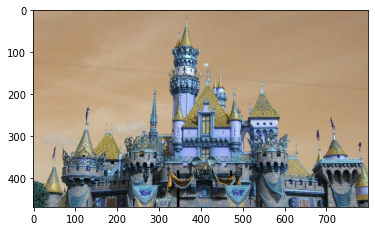

In [23]:
# 높은 해상도의 이미지 불러오기
import cv2
my_image_path = os.getenv('HOME')+'/aiffel/super_resolution/disney.jpg'

img_bgr = cv2.imread(my_image_path)
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
plt.imshow(img_bgr)

In [ ]:
# 자세히 시각화 하기 위해 3개 영역을 잘라냅니다.
# 아래는 잘라낸 부분의 좌상단 좌표 3개 입니다.
left_tops = [(400,500), (300,1200), (0,1000)]

images = []
for left_top in left_tops:
    img1 = crop(bicubic_hr, left_top, 200, 200)
    img2 = crop(srgan_hr , left_top, 200, 200)
    img3 = crop(hr, left_top, 200, 200)
    images.extend([img1, img2, img3])

labels = ["Bicubic", "SRGAN", "HR"] * 3

plt.figure(figsize=(18,18))
for i in range(9):
    plt.subplot(3,3,i+1) 
    plt.imshow(images[i])
    plt.title(labels[i], fontsize=30)